1. Installing MNE and MNE_CONNECTIVITY

In [1]:
!pip install mne
!pip install mne_connectivity

2. Importing modules

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import mne_connectivity
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

<module 'spectrogram_plotting_functions' from 'c:\\Users\\Thomas\\Desktop\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

3. Generating synthetic data to test mne

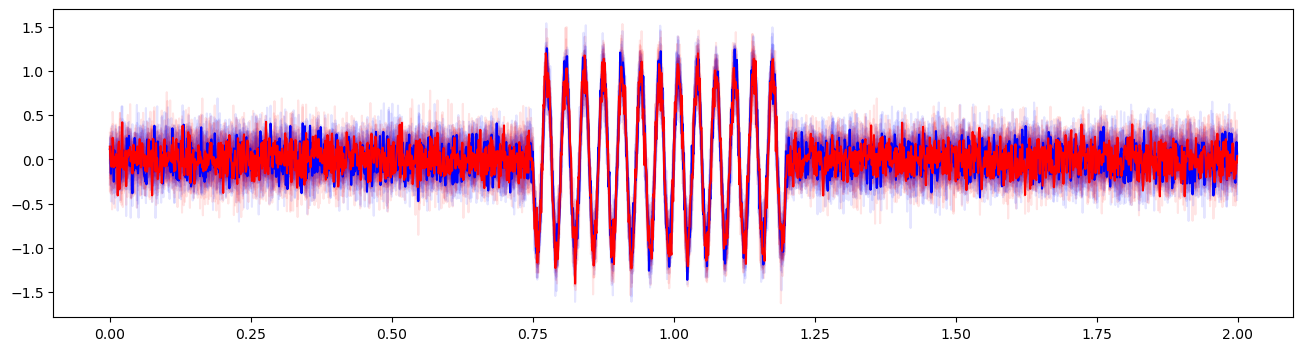

In [5]:
osc = np.sin(2 * np.pi * times[:] * 30)[750:1200]
trials = 10
fs=1000
times = np.arange(0, 2, 1/fs)

epochs = np.empty((trials, 2, len(times)))
plt.figure(figsize=(16,4))

for trial in range(0, trials):
    lfp1 = np.random.normal(0, .2, size=times.shape)
    lfp2 = np.random.normal(0, .2, size=times.shape)
    lfp1[750:1200] += osc
    lfp2[750:1200] += osc
    epochs[trial, 0, :] = lfp1
    epochs[trial, 1, :] = lfp2
    plt.plot(times, lfp1, label='lfp1', color='blue', alpha=0.1)
    plt.plot(times, lfp2, label='lfp2', color='red', alpha=0.1)
plt.plot(times, np.mean(epochs[0,:,:], axis=0), color='blue', label='lfp1')
plt.plot(times, np.mean(epochs[1,:,:], axis=0), color='red',label='lfp2')

3.2 Now we test the coherence function on the generated data

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.999s for estimation (2000 points)
    frequencies: 3.0Hz..99.0Hz (97 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]


Text(0, 0.5, 'Frequency (Hz)')

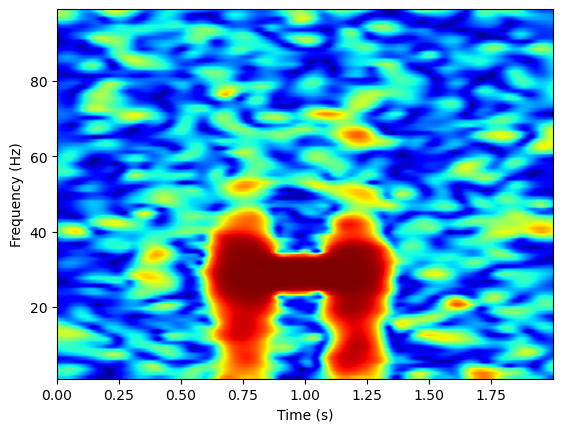

In [6]:
freqs = np.arange(1,100)
n_cycles = freqs/2
con = mne_connectivity.spectral_connectivity_epochs(epochs, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))                                                   
coh = con.get_data()

plt.imshow(np.squeeze(coh), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

4. Loading up the real data

In [8]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello Thomas
['C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_noconte

In [9]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [10]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
files=['C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat']
event_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
before_data_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
scrambled_baseline_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
averaged_data=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
averaged_data_welch=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
random_baseline_data=[]
for file in files:
    #if 'dk6' in file:
        
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)

        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]

        mne_epoch_door_before=np.zeros((len(epochs),len(aon_lfp_channels),4000))
        mne_epoch_door_after=np.zeros((len(epochs),len(aon_lfp_channels),4000))
        mne_epoch_dig_before=np.zeros((len(epochs),len(aon_lfp_channels),4000))
        mne_epoch_dig_after=np.zeros((len(epochs),len(aon_lfp_channels),4000))
        first_event = events_times[0]
        for channel_num,channeli in enumerate(aon_lfp_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)

                normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)

                total = normalized_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    mne_epoch_door_before[i,channel_num,:]=list(data_door_before)
                    mne_epoch_door_after[i,channel_num,:]=list(data_door_after)
                    mne_epoch_dig_before[i,channel_num,:]=list(data_dig_before)
                    mne_epoch_dig_after[i,channel_num,:]=list(data_dig_after)


C:\Users\Thomas\Dropbox\CPLab\all_data_mat_filtered\20230529_dk1_nocontext.mat
20230529 dk1 nocontext
20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
49.0
181.20385499999998 120.0 182.713855 49.0
4000 4000
4000 4000
48.0
237.771855 120.0 239.46185499999999 48.0
4000 4000
4000 4000
49.0
279.551855 120.0 280.29184999999995 49.0
4000 4000
4000 4000
48.0
348.953855 120.0 349.84385 48.0
4000 4000
4000 4000
49.0
466.78984999999994 120.0 468.25985499999996 49.0
4000 4000
4000 4000
49.0
526.9038549999999 120.0 528.223855 49.0
4000 4000
4000 4000
49.0
570.771855 120.0 571.4418549999999 49.0
4000 4000
4000 4000
48.0
617.237855 120.0 618.4178549999999 48.0
4000 4000
4000 4000
49.0
669.49786 120.0 670.737855 49.0
4000 4000
4000 4000
49.0
705.3358549999999 120.0 706.5758549999999 49.0
4000 4000
4000 4000
(1516022,) (1516022,) 2000
notch filter appli

5. Calculating Spectral connectivity and plotting it

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 6 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 3.0Hz..99.0Hz (97 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1


C:\Users\Thomas\AppData\Local\Temp\ipykernel_24288\686939299.py:10: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 10>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(mne_epoch_dig_after, method='coh', sfreq=int(fs),


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
(4, 4, 97, 4000)
Connection indices: ['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON']


Text(0, 0.5, 'Frequency (Hz)')

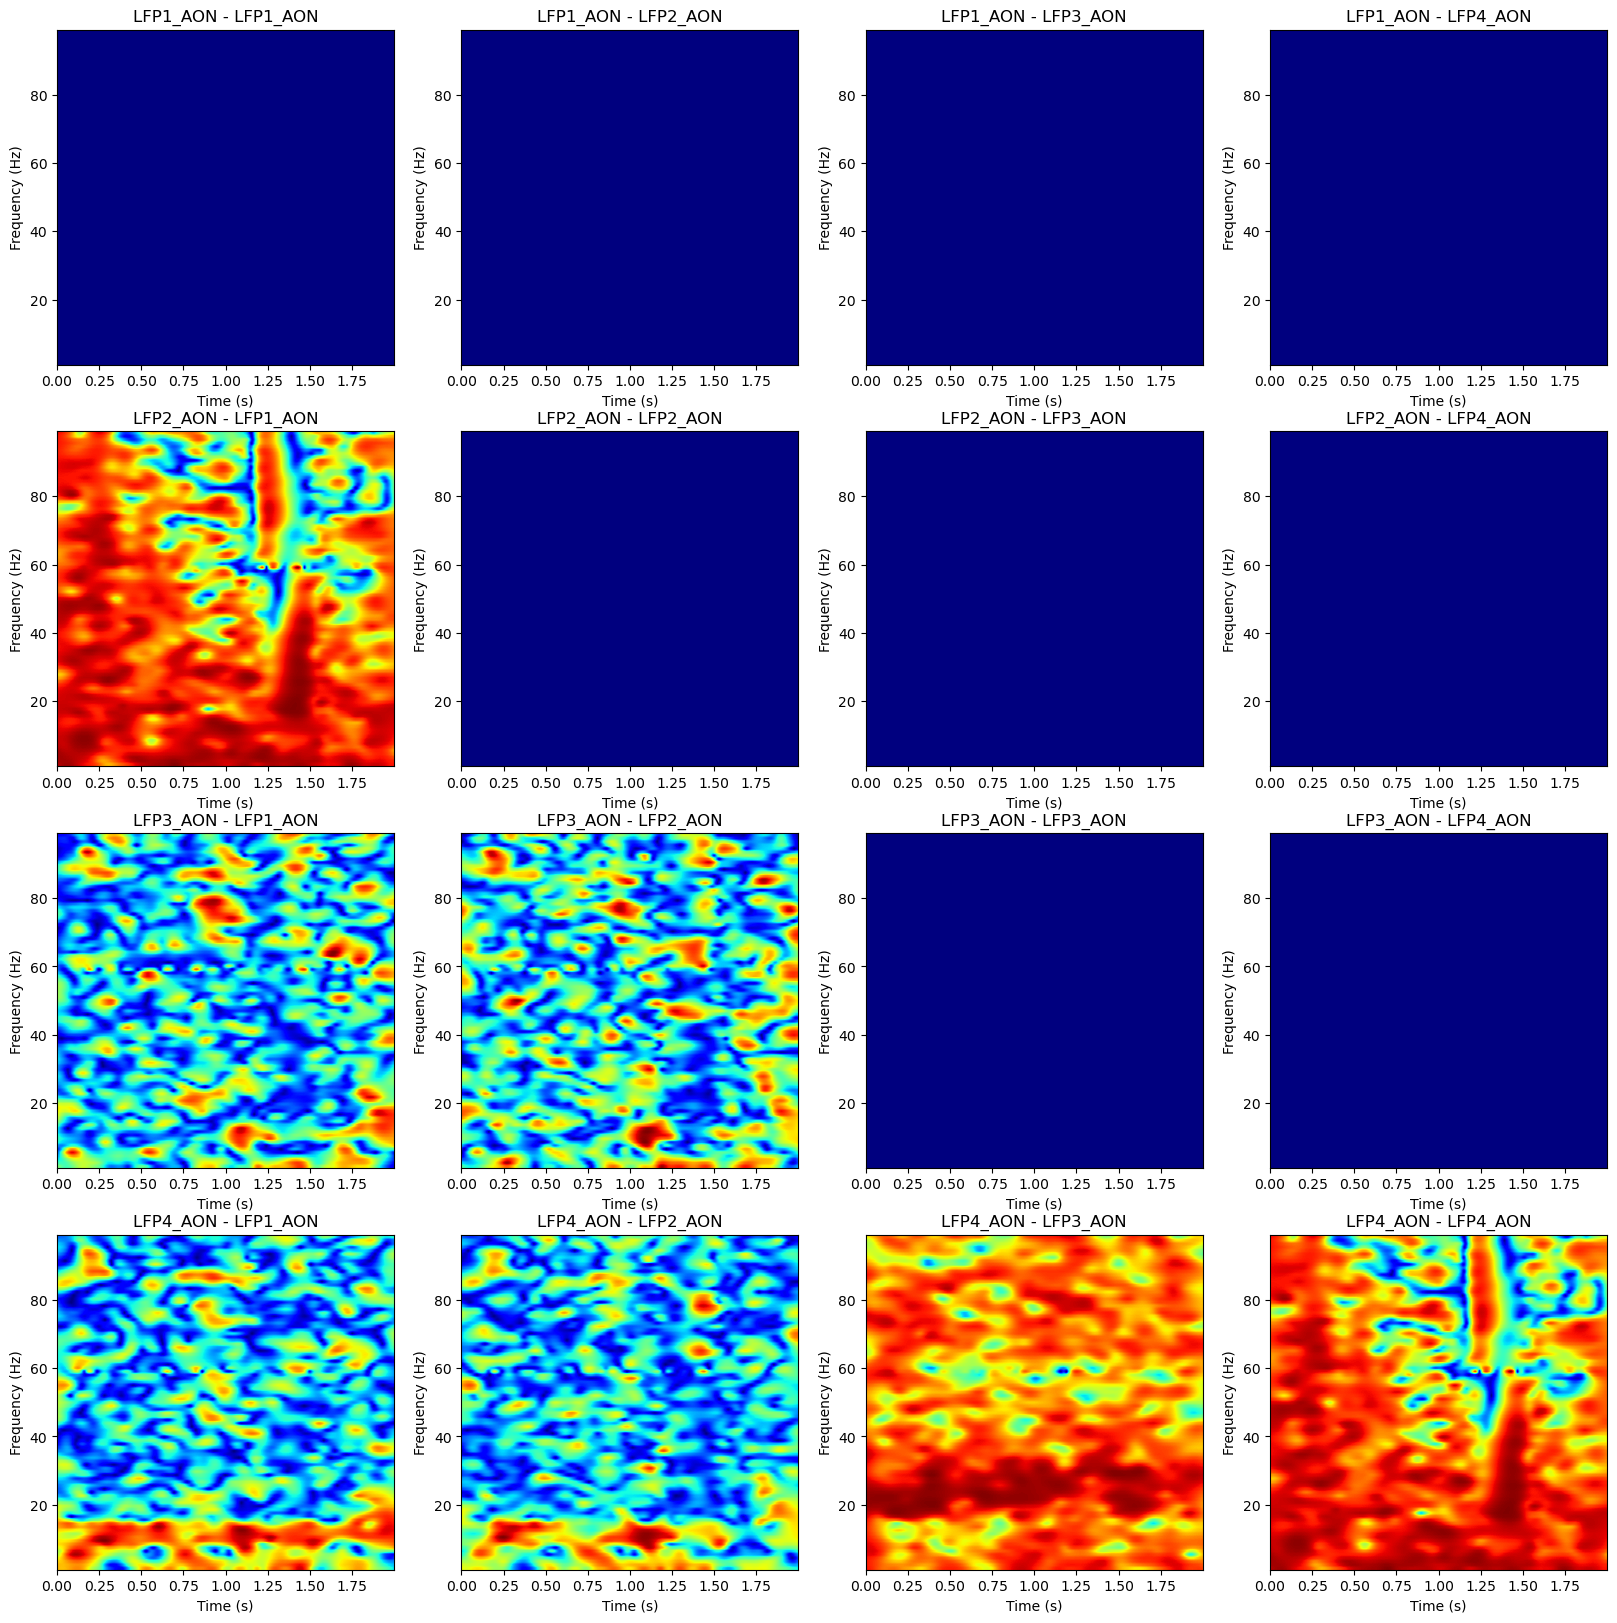

In [26]:
fs=2000
freqs = np.arange(1,100)
n_cycles = freqs/2
info = mne.create_info(ch_names=aon_lfp_channels, sfreq=fs, ch_types='eeg')
mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)

con = mne_connectivity.spectral_connectivity_epochs(mne_epoch_dig_after, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True)

coh = con.get_data(output='dense')


print(coh.shape)

# Access the connection indices
indices = con.names
print("Connection indices:", indices)
fig, axs = plt.subplots(4,4 , figsize=(20, 20))

for i in range(4):
    for j in range(4):
        axs[i,j].imshow(np.squeeze(coh[i,j,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        axs[i,j].set_title('{} - {}'.format(aon_lfp_channels[i], aon_lfp_channels[j]))

plt.imshow(np.squeeze(coh[1,0,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_reshaped = mne_epoch_door_before.reshape(-1, 4000)  # Reshape to (n_epochs * n_channels, n_times)
data_normalized = scaler.fit_transform(data_reshaped)
data_normalized = data_normalized.reshape(len(epochs), len(lfp_channels), 4000)  # Reshape back to (n_epochs, n_channels, n_times)

info = mne.create_info(ch_names=channels, sfreq=2000.0, ch_types='misc')



In [27]:
# Create MNE EpochsArray
mne_epoch_door_before = mne.EpochsArray(data_normalized, info)

# Plot the data
fig = mne_epoch_door_before.plot(picks=np.arange(1, 8), n_epochs=10)


fig.show()

# info=mne.create_info(ch_names=channels,sfreq=2000.0,ch_types='misc')
# mne_epoch_door_before=mne.EpochsArray(mne_epoch_door_before,info)
# #fig,axs=plt.subplots(1,1,figsize=(30,10))
# fig=mne_epoch_door_before.plot(picks=np.arange(1,8),n_epochs=10)
# fig.show()

ValueError: Info and data must have same number of channels.

In [21]:
!pip install mne_connectivity

In [ ]:
import mne
import mne_connectivity


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 6 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 3.0Hz..99.0Hz (97 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


In [ ]:
%matplotlib inline
print(coh.shape)
plt.imshow(np.squeeze(coh[,:,:]), extent=[0, 2, freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

SyntaxError: invalid syntax (1579395256.py, line 4)

In [37]:
print(coh)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

C:\Users\Thomas\AppData\Local\Temp\ipykernel_67096\1184834707.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


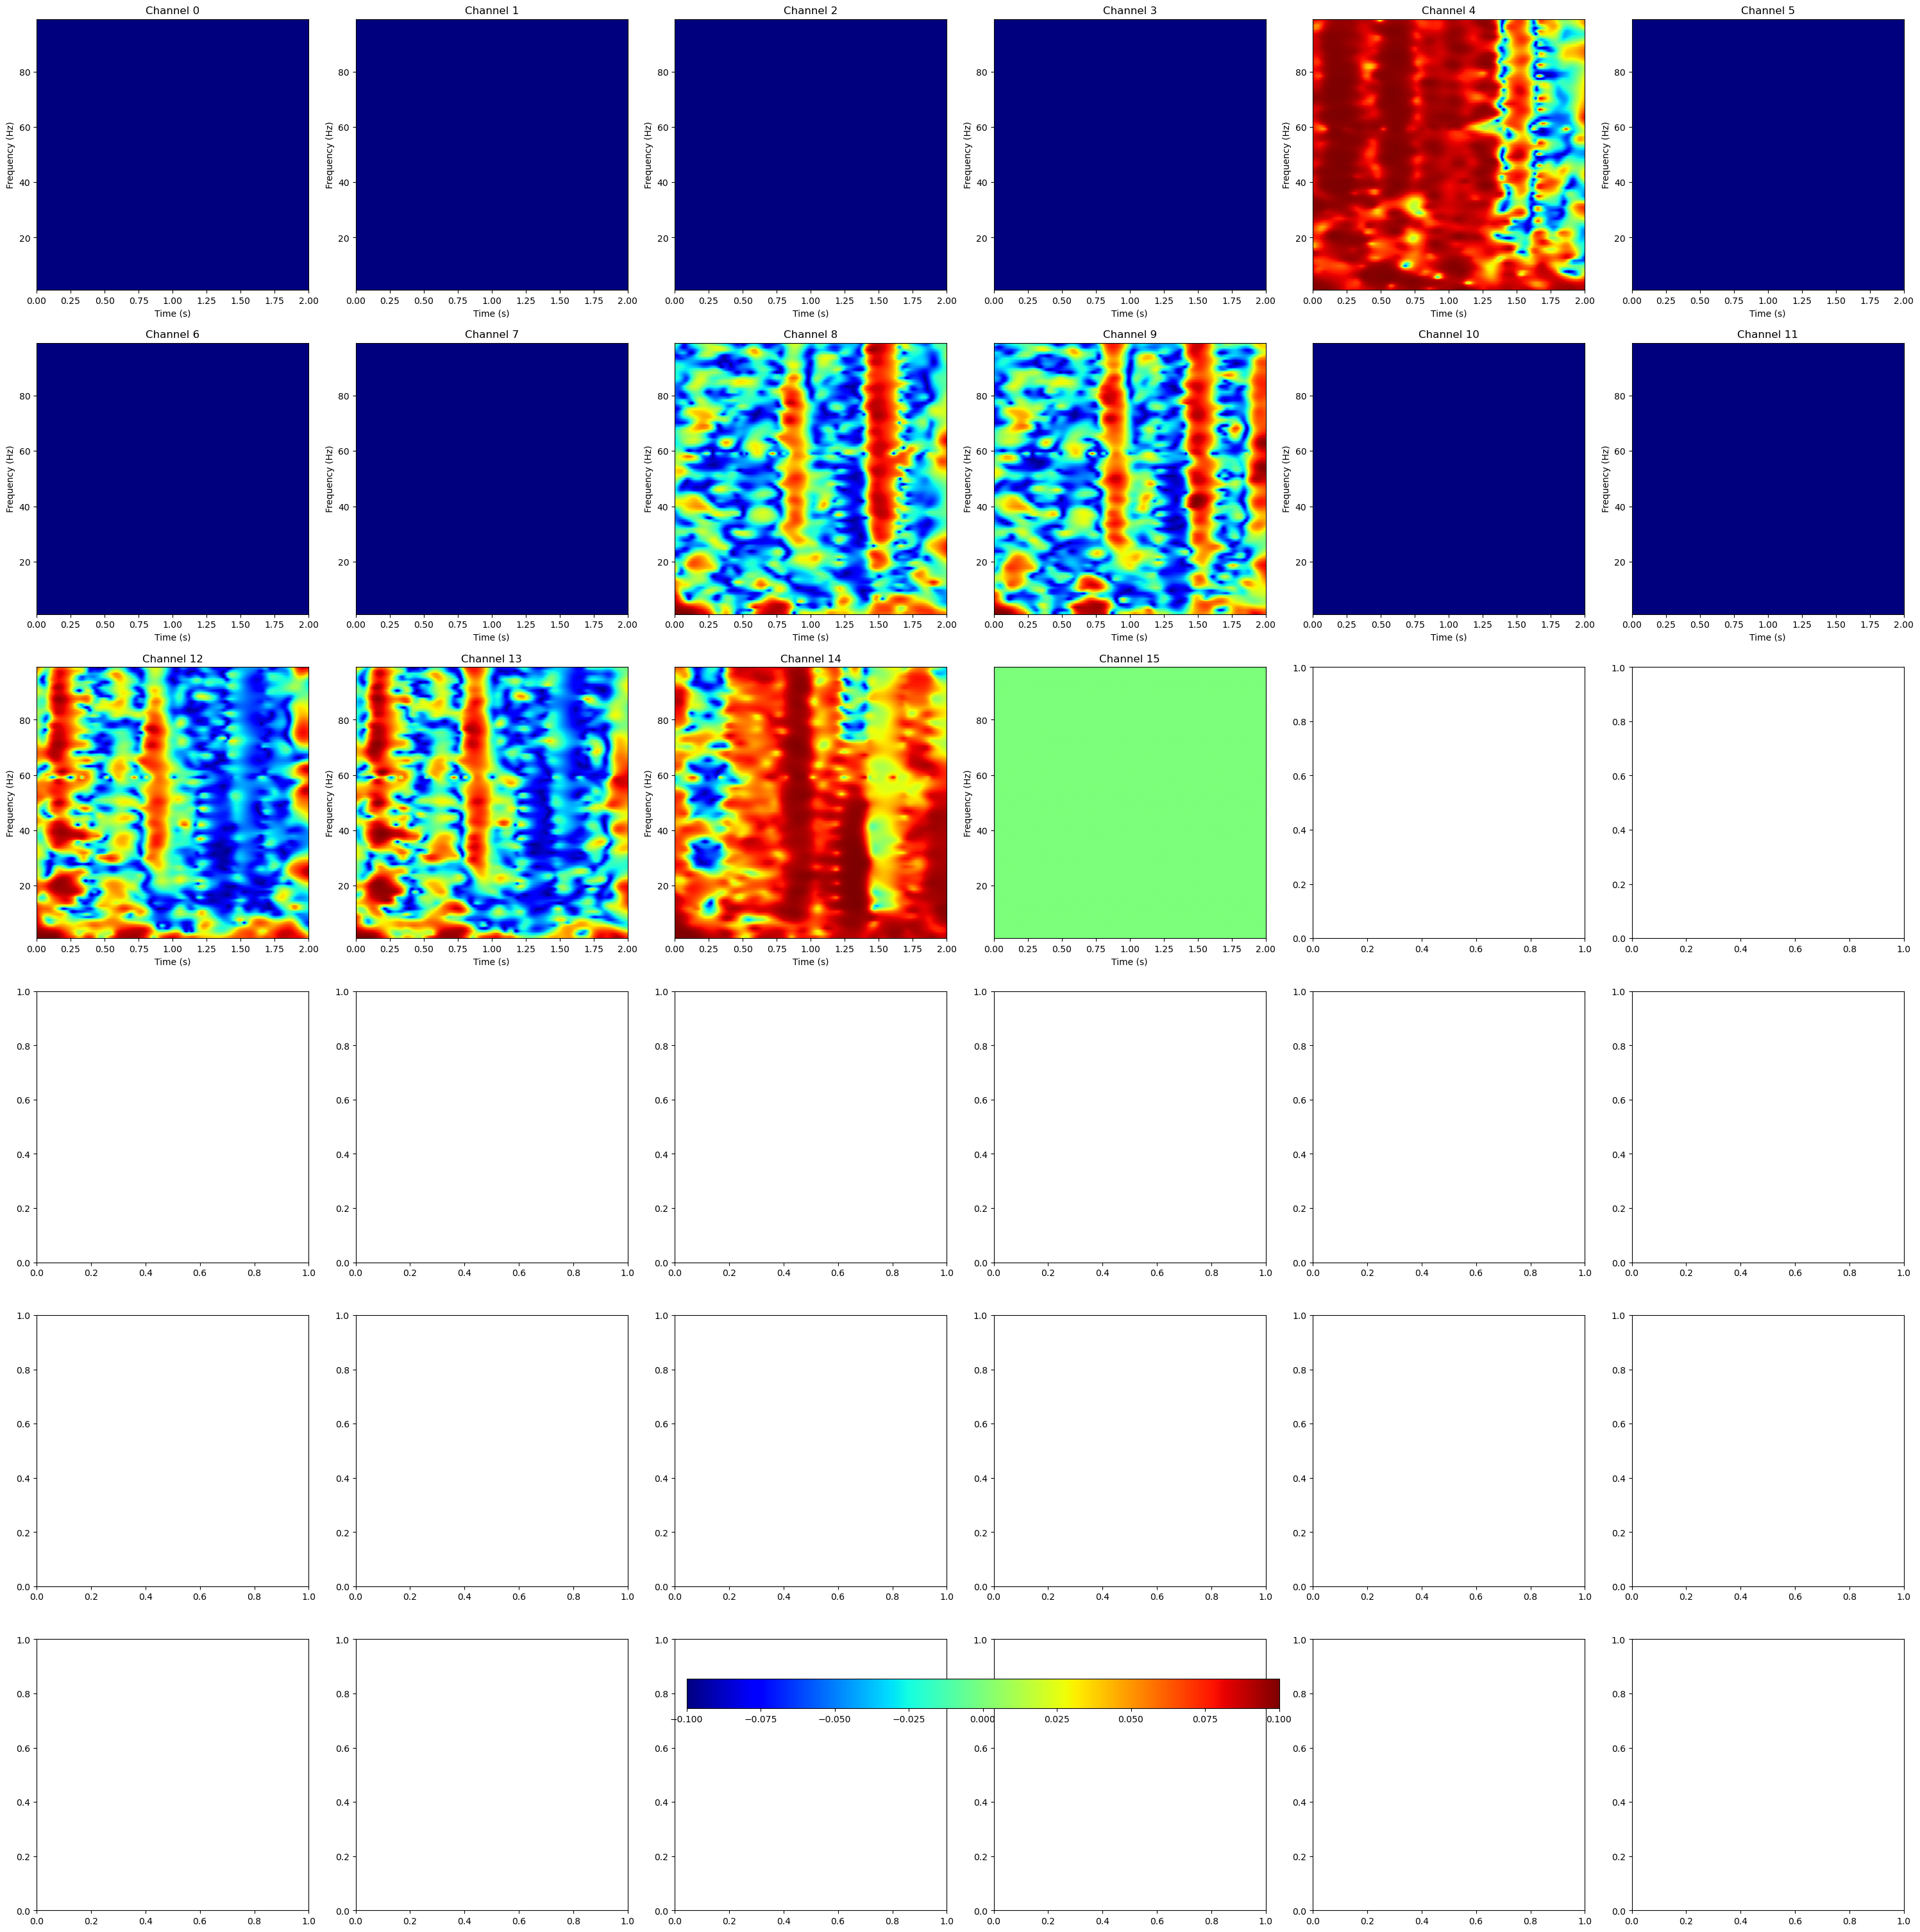

In [40]:
coh = con.get_data()

fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs = axs.flatten()

for i in range(coh.shape[0]):
    im = axs[i].imshow(np.squeeze(coh[i, :, :]), extent=[0, 2, freqs[0], freqs[-1]],
                       aspect='auto', origin='lower', cmap='jet')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title('Channel {}'.format(i))

# Add a colorbar
fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()